In [2]:
from transformers import AutoTokenizer, BertForQuestionAnswering, AutoModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
model = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")

question, text = "He was a great athlete", "He was a good athlete"

inputs = tokenizer(question, text, return_tensors='pt')

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
inputs

{'input_ids': tensor([[ 101, 1124, 1108,  170, 1632, 8765,  102, 1124, 1108,  170, 1363, 8765,
          102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
inputs.input_ids.shape

torch.Size([1, 13])

In [6]:
ticks = []
for i in range(len(inputs.input_ids[0])):
    print(inputs.input_ids[0][i], ':', tokenizer.decode(inputs.input_ids[0][i]))
    ticks.append(tokenizer.decode(inputs.input_ids[0][i]))

tensor(101) : [CLS]
tensor(1124) : He
tensor(1108) : was
tensor(170) : a
tensor(1632) : great
tensor(8765) : athlete
tensor(102) : [SEP]
tensor(1124) : He
tensor(1108) : was
tensor(170) : a
tensor(1363) : good
tensor(8765) : athlete
tensor(102) : [SEP]


In [7]:
ticks

['[CLS]',
 'He',
 'was',
 'a',
 'great',
 'athlete',
 '[SEP]',
 'He',
 'was',
 'a',
 'good',
 'athlete',
 '[SEP]']

In [8]:
outputs.keys()

odict_keys(['start_logits', 'end_logits', 'hidden_states', 'attentions'])

In [9]:
len(outputs.hidden_states)

13

In [10]:
for i in range(13):
    print(outputs.hidden_states[i].shape)

torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])
torch.Size([1, 13, 768])


In [11]:
len(outputs.attentions)

12

In [12]:
attentions = []
for attention in outputs.attentions:
    attentions.append(attention.numpy())

attentions = torch.tensor(np.array(attentions)) 

In [13]:
attentions.shape

torch.Size([12, 1, 12, 13, 13])

In [14]:
attentions[0].shape

torch.Size([1, 12, 13, 13])

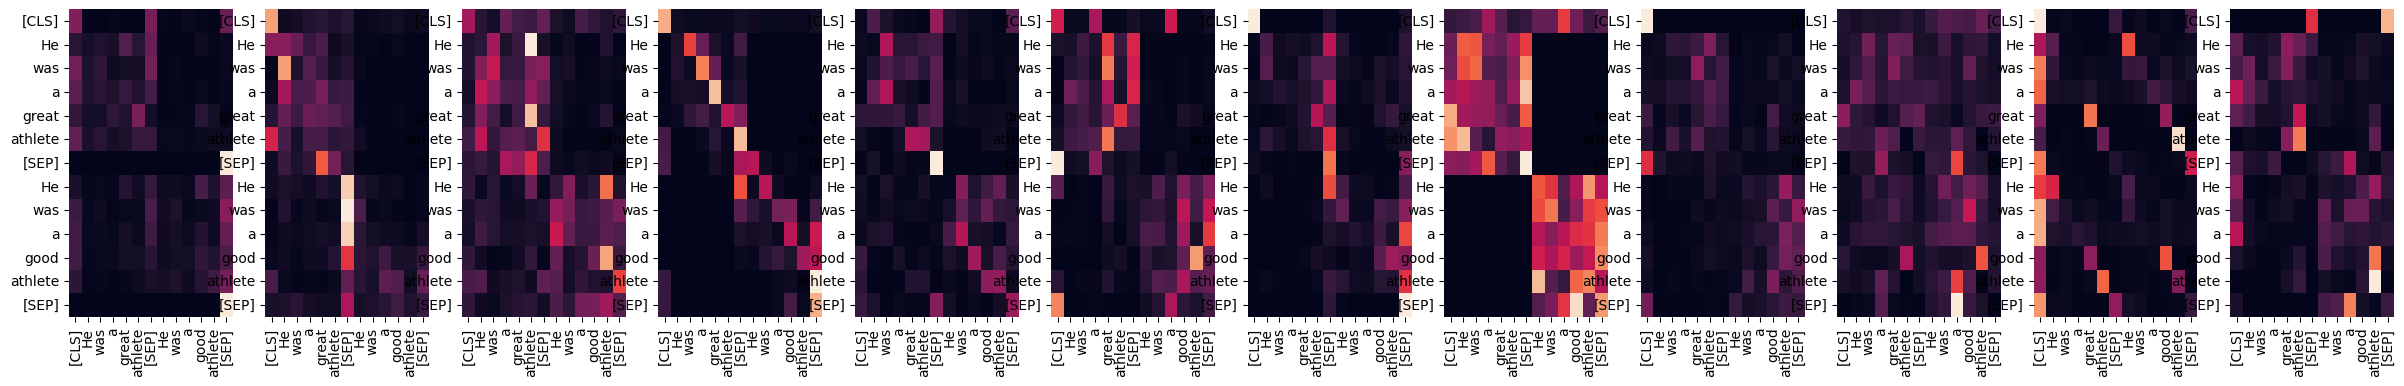

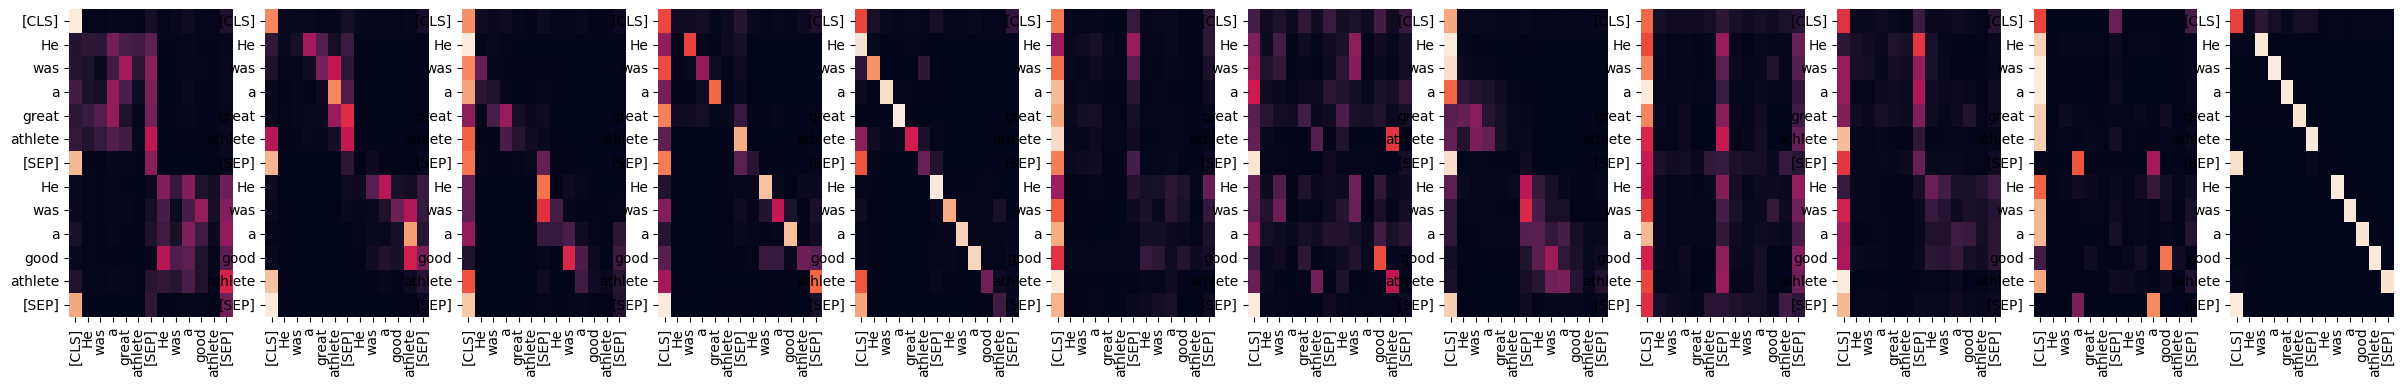

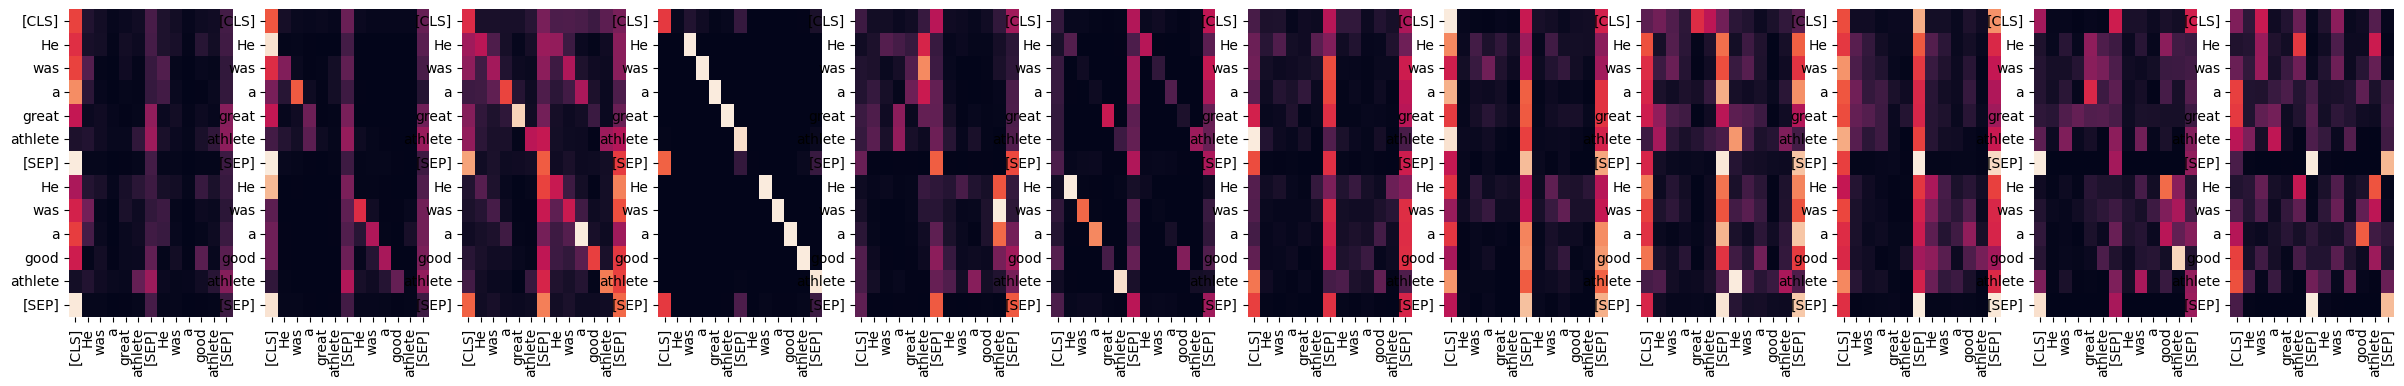

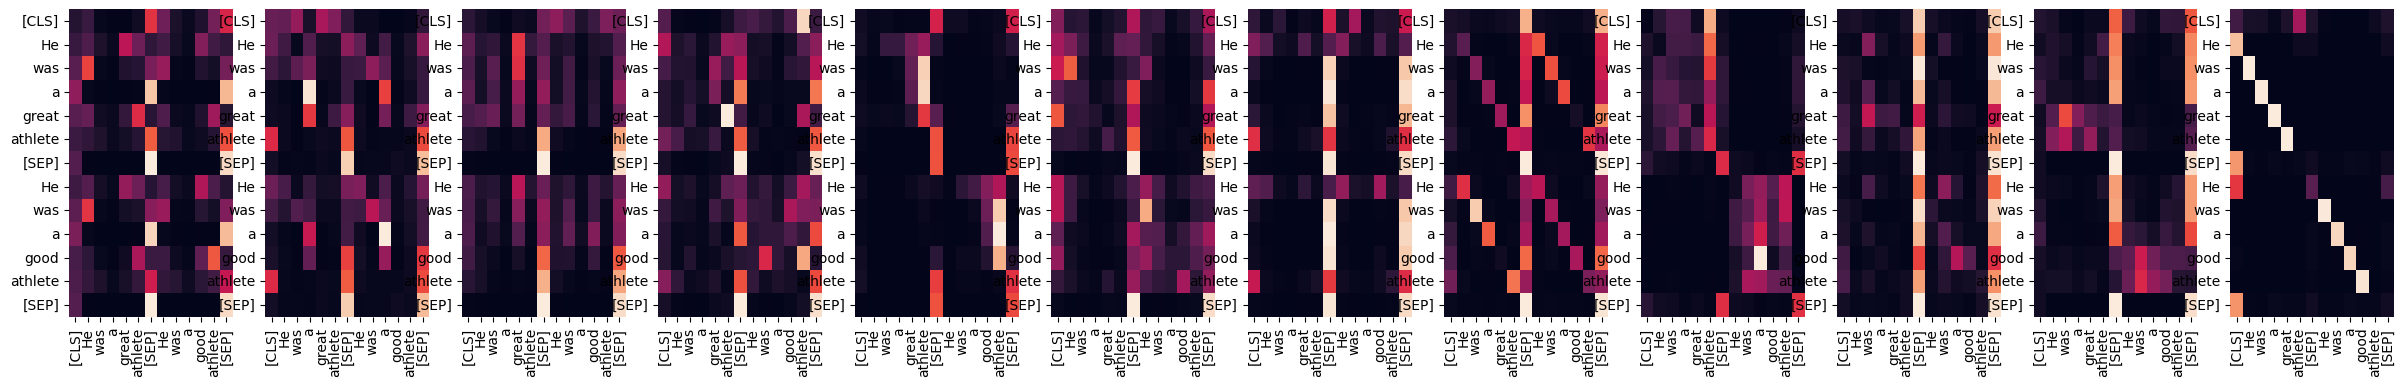

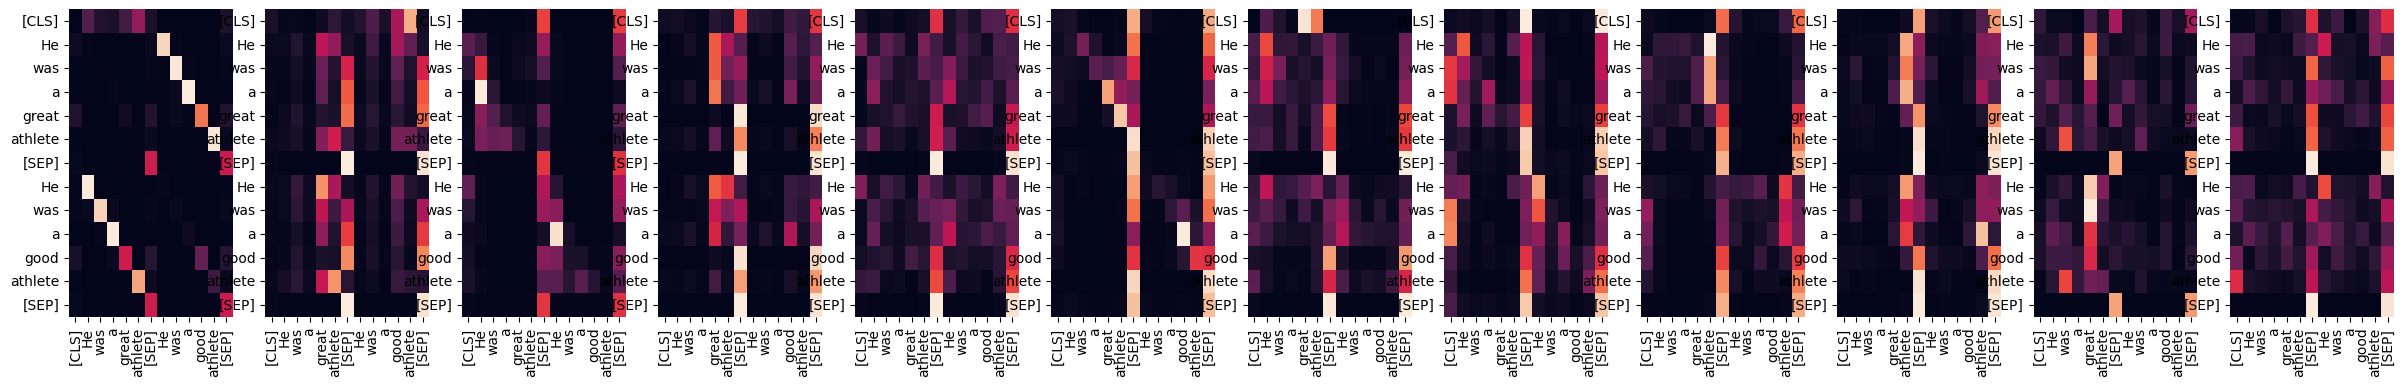

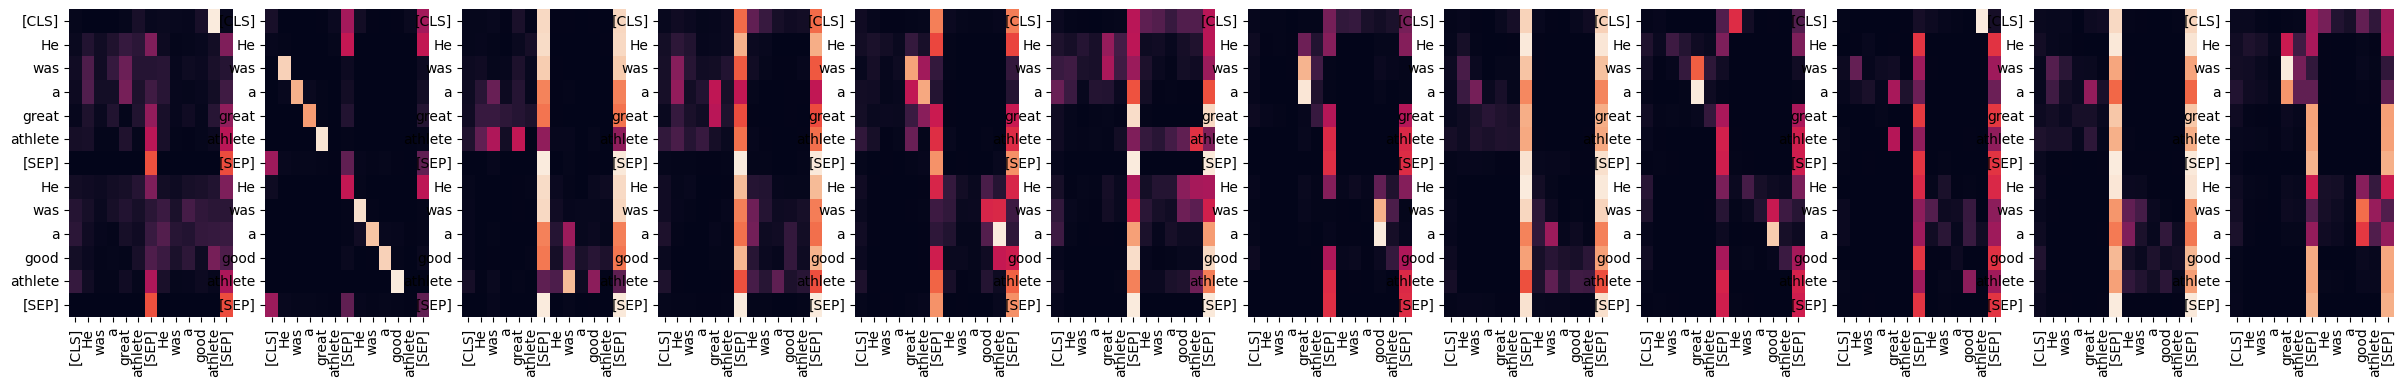

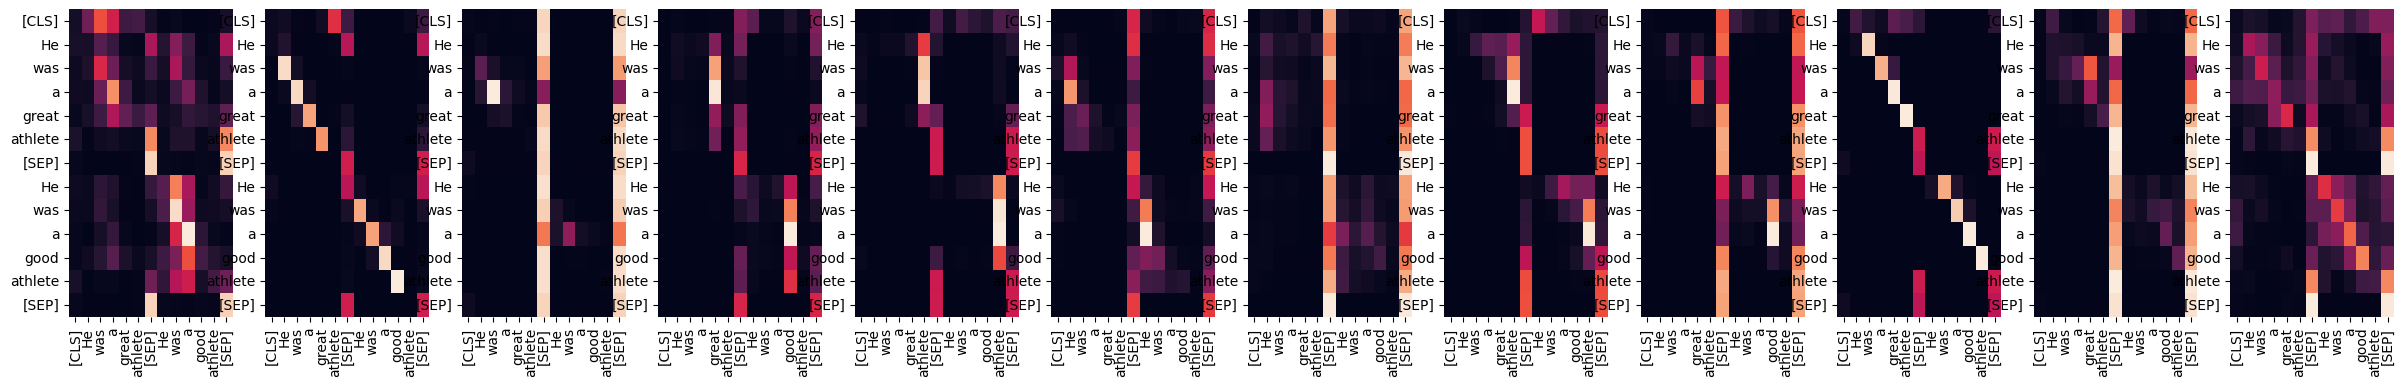

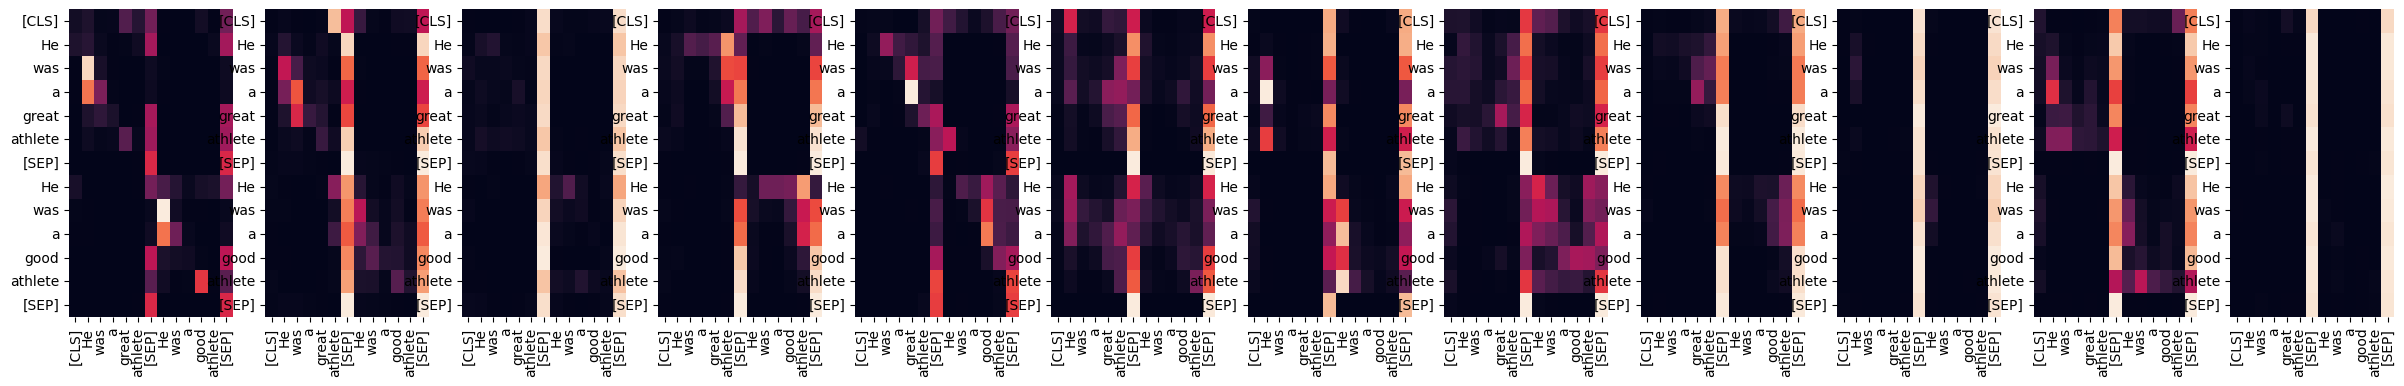

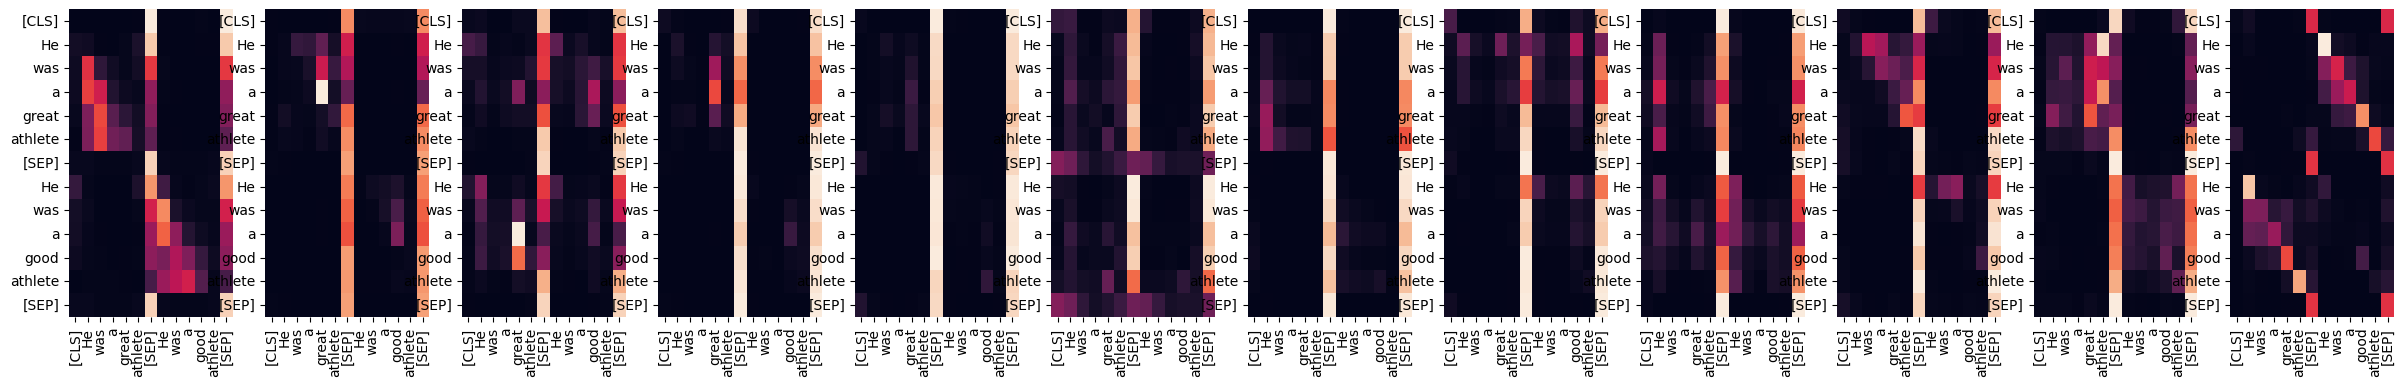

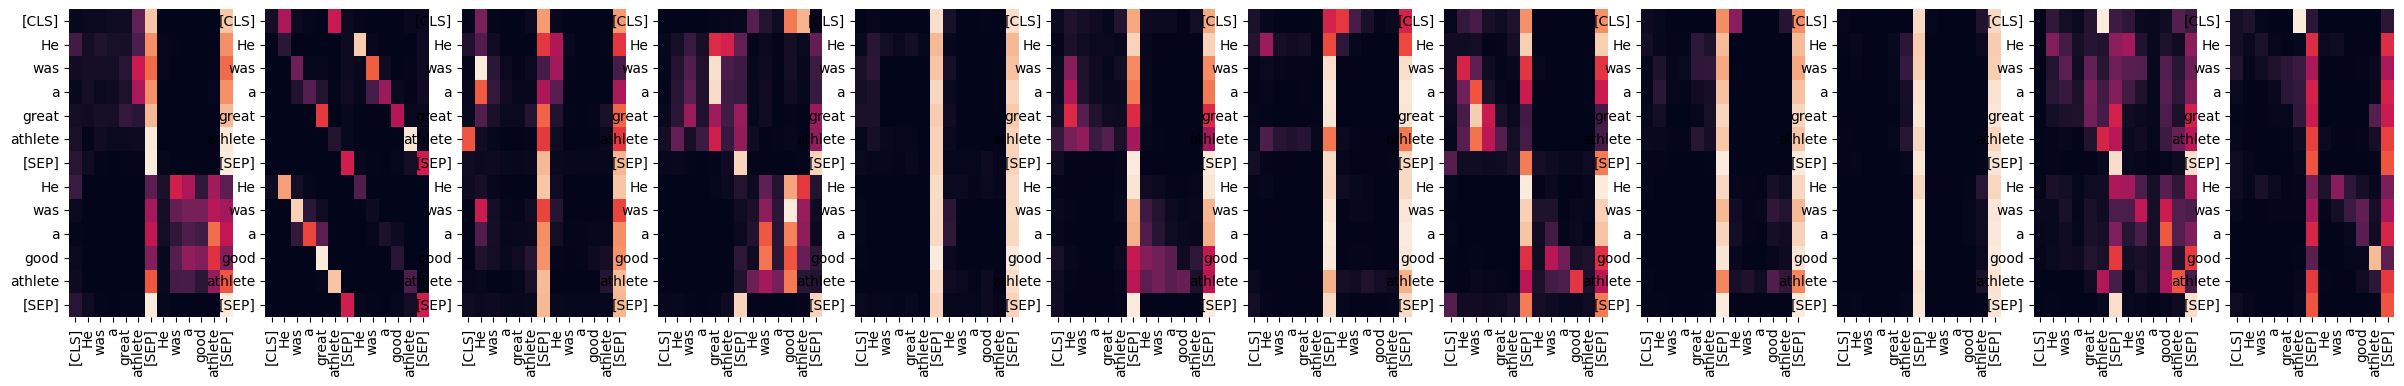

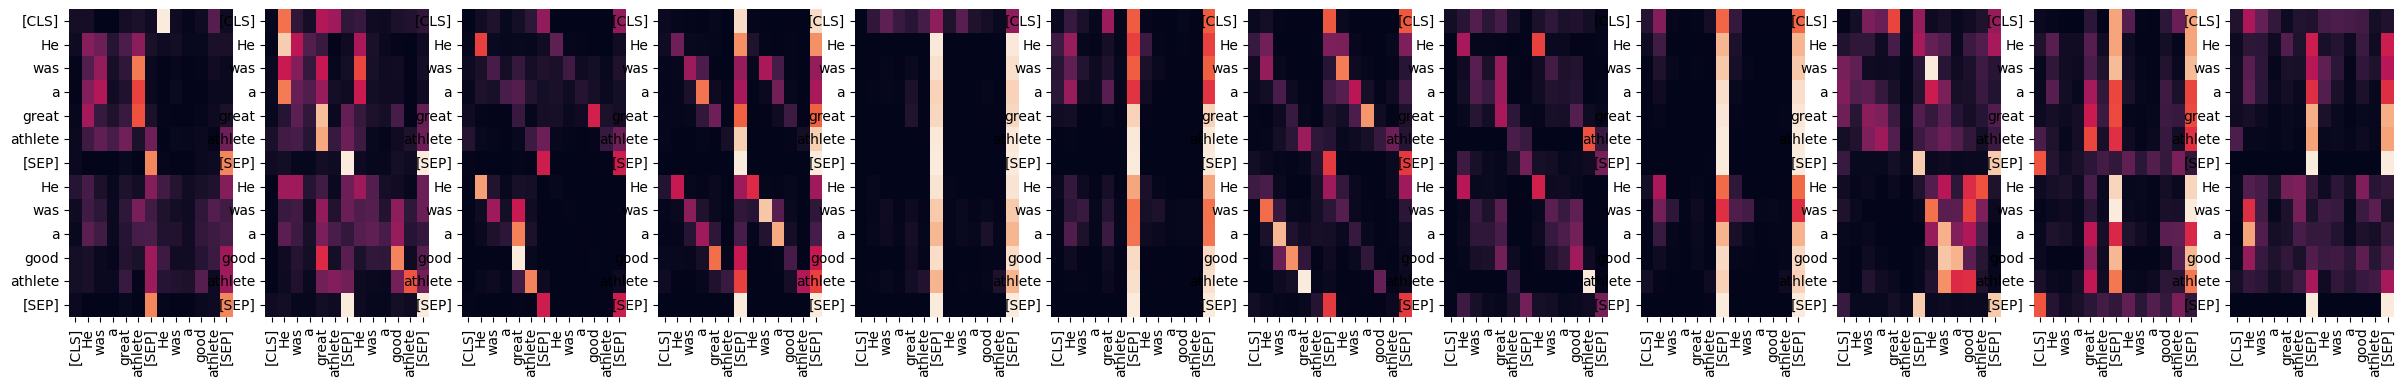

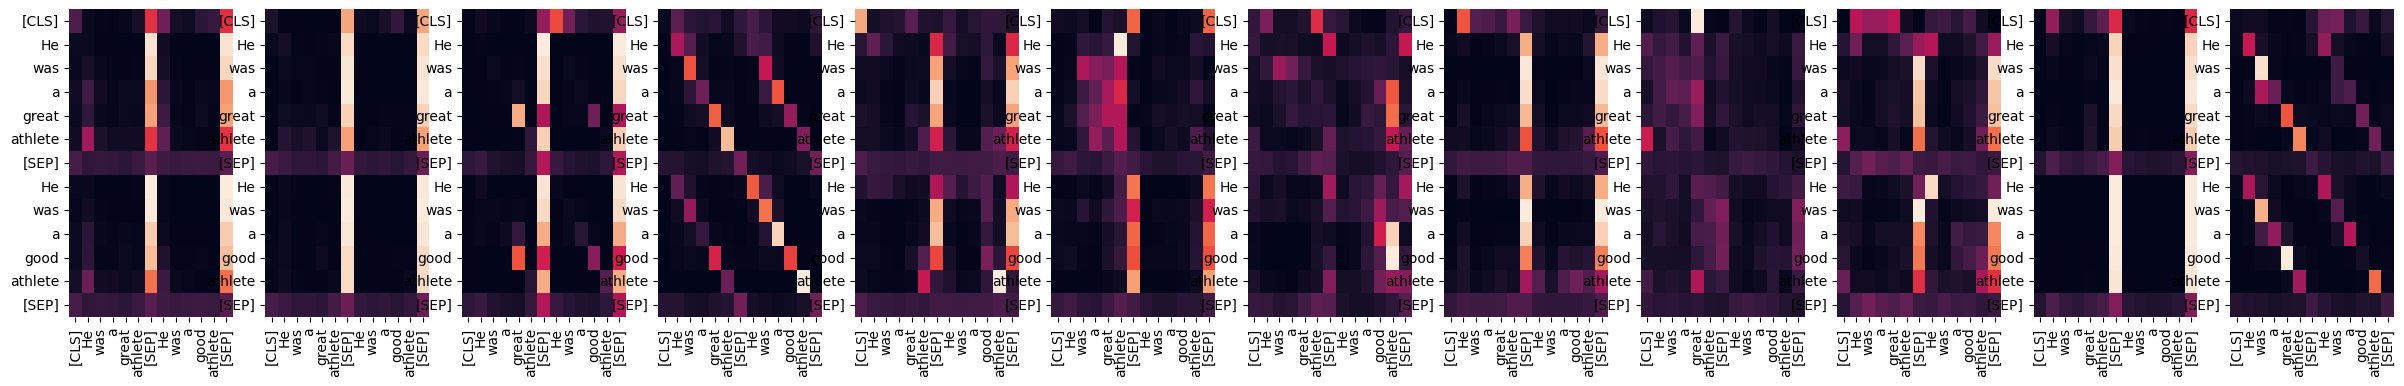

In [15]:
for i in range(12):
    plt.figure(figsize=(30,4))
    for j in range(12):    
        plt.subplot(1, 12, j+1)
        sns.heatmap(data=attentions[i][0, j].numpy(), xticklabels=ticks, yticklabels=ticks, cbar=False)
    plt.show()
        

In [16]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view
# from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, BertForQuestionAnswering

model_version = 'deepset/bert-base-cased-squad2'
model = BertForQuestionAnswering.from_pretrained(model_version, output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)
sentence_a = question
sentence_b = text
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
attention_tensors = []

for tensor in model(input_ids, token_type_ids=token_type_ids).attentions:
    attention_tensors.append(tensor.detach().numpy())

attentions_temp = torch.tensor(np.array(attention_tensors))

In [18]:
attentions_temp.shape

torch.Size([12, 1, 12, 13, 13])

In [19]:
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [20]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [21]:
def get_word_idx(sent: str, word: str):
     return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
    Select only those subword token outputs that belong to our word of interest
    and average them."""
    with torch.no_grad():
        output = model(**encoded)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
    that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)

    return get_hidden_states(encoded, token_ids_word, model, layers)


def main(layers=None):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

    sent = "I like cookies ." 
    idx = get_word_idx(sent, "cookies")

    word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)
    
    return word_embedding 

In [22]:
main()

tensor([-5.5028e-01,  1.8190e-01,  4.4018e+00,  2.4194e+00, -2.4089e+00,
        -2.3311e+00, -5.0146e-01, -2.1046e+00, -3.0087e+00, -2.9013e+00,
        -4.4350e-01, -3.0155e+00, -6.6546e+00,  1.3540e+00,  8.5094e-01,
        -1.7450e-01, -8.2674e-01,  2.0520e+00, -1.7848e+00, -2.0914e+00,
        -1.3772e+00,  1.0321e+00, -1.6078e+00, -1.4072e+00, -3.2613e+00,
         7.3652e-01,  7.0560e+00,  3.9058e+00,  8.6905e-01,  3.4249e+00,
        -2.1585e+00, -2.0917e-01,  1.4680e+00, -2.0364e+00, -2.0594e+00,
         7.7027e-02, -8.2810e-01, -2.6956e+00,  3.2890e-01,  1.8194e+00,
        -6.9227e-01, -3.0766e-01,  1.8073e+00,  1.9182e+00,  2.9320e+00,
         1.3646e+00,  2.3034e+00, -1.6550e+00,  2.0512e+00,  9.6843e-01,
        -1.2411e+00,  4.9699e-01, -3.7587e-01, -7.2980e-01,  2.1502e+00,
        -1.0838e+00, -2.0453e+00,  1.3343e+00,  2.5721e-01, -3.5573e-02,
        -4.2791e+00, -1.6080e+00, -1.7981e+00,  1.8884e+00,  1.2026e+00,
        -2.5210e+00,  1.8392e+00,  5.5198e-01,  4.5